This notebook analyzes the campaigns speeches of Clinton and Trump.
It uses topic modeling, along with signature computation

In [1]:
%matplotlib inline

In [2]:
import json

import numpy as np
import os
import re
import html

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn import cluster
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk.help
import nltk
#from textblob import TextBlob

import datetime

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

from scipy.sparse import find

from code_these_clement.utils.signature_func import compute_sky_signature

In [3]:
# We load the annotated speeches (speech with speaker name, date and event)
annotated_speeches_path = r"C:\Users\cgautrai\workspace\repo_these\code_these_clement\scraping\pres_speeches\annotated_speeches.json"
speeches = []
with open(annotated_speeches_path) as annotated_speeches_file:
    speeches = json.load(annotated_speeches_file)
    speeches = sorted(speeches, key=lambda o:datetime.datetime.strptime(o["date"], "%B %d, %Y").timestamp())
    #speeches = [s for s in speeches if datetime.datetime.strptime(s["date"], "%B %d, %Y") > datetime.datetime(2016, 3, 1)]

In [4]:
# This is the function that processes the raw data and return a list of currated speeches
def get_processed_speeches(politician):
    politician_speeches = []
    
    cachedStopWords = stopwords.words("english")
    # We also remove way too frequent words
    cachedStopWords.extend(["clinton", "trump", "donald", "hillary", "america", "american", "country", "people", "lot", "mr"])
    # We only keep some POS tags
    kept_pos_tags = ["FW", "JJ", "JJR", "JJS", "NN", "NNS"]# "NNP", "NNPS"]#, "RBR", "RBS"]# "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
    lmtzr = WordNetLemmatizer()
    for speech in speeches:
        politician_talks = []
        for paragraph in speech["annotated_text"]:
            if politician.upper() in paragraph["speaker"].upper():
                politician_talks.append(html.unescape(paragraph["text"]))
        if politician_talks:
            overall_speech = " ".join(politician_talks)
            #blob = TextBlob(overall_speech)
            # We'll do a smarter thing by filtering by pos tags
            #speech_nouns = " ".join(blob.noun_phrases)
            tokenized_speech_words = word_tokenize(overall_speech)
            pos_tags = nltk.pos_tag(tokenized_speech_words)
            lemmatized_speech_words = [lmtzr.lemmatize(w.lower()) for i,w in enumerate(tokenized_speech_words) if pos_tags[i][1] in kept_pos_tags]
            speech_words = [w for w in lemmatized_speech_words if w not in cachedStopWords]
            politician_speeches.append(" ".join(speech_words))
    return politician_speeches

In [5]:
def get_speeches_dates(politician):
    all_dates = []
    for speech in speeches:
        for paragraph in speech["annotated_text"]:
            if politician.upper() in paragraph["speaker"].upper():
                all_dates.append(datetime.datetime.strptime(speech["date"], "%B %d, %Y"))
                break
    return all_dates

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] + ":" + '{:.4f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [7]:
clinton_speeches = get_processed_speeches("Clinton")
trump_speeches = get_processed_speeches("Trump")
all_speeches = clinton_speeches[:]
all_speeches.extend(trump_speeches)

# We now transform tweets using vectorizers
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_vectors = tfidf_vectorizer.fit_transform(all_speeches)

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.8)
count_vectors = count_vectorizer.fit_transform(all_speeches)

In [8]:
print(len(clinton_speeches))
print(len(trump_speeches))
print(len(all_speeches))
print(len(count_vectorizer.vocabulary_))

93
71
164
6240


In [9]:
# Fit the NMF model
n_topics = 15
n_top_words = 15
nmf = NMF(n_components=n_topics, alpha=.1, l1_ratio=.1, random_state=1).fit(count_vectors)

print("\nTopics in NMF model:")
tfidf_feature_names = count_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
business:6.4329 small:3.8615 tax:3.5096 kind:2.8658 college:1.4745 company:1.4512 work:1.4087 worker:1.3512 economy:1.3338 big:1.3025 everybody:1.2302 community:1.2222 sure:1.2002 important:1.0582 high:1.0403
Topic #1:
school:5.3915 student:2.8252 choice:2.6607 education:1.9598 child:1.7967 african:1.5208 policy:1.2792 dollar:1.2611 new:1.2557 city:1.2516 american:1.2273 future:1.1934 percent:1.1679 public:1.1484 poverty:1.1269
Topic #2:
kid:6.9124 child:3.8236 school:3.7620 parent:2.7433 care:2.2905 education:1.5282 hard:1.4737 early:1.3431 kind:1.2307 quality:1.1852 teacher:1.0656 program:1.0146 best:0.9741 better:0.9686 support:0.9686
Topic #3:
terrorist:3.5042 attack:1.9469 threat:1.8242 fight:1.6940 new:1.6540 security:1.4752 ground:1.3639 coalition:1.3456 force:1.3235 effort:1.3221 intelligence:1.3010 fighter:1.2651 partner:1.2541 support:1.2486 terrorism:1.2067
Topic #4:
money:2.9117 big:2.7544 deal:2.4308 percent:2.2212 place:2.0004 right:1.8752 

In [10]:
# Hand crafted labels for each topic: CHANGE THAT IF YOU CHANGE THE TOPIC MODELING CODE
# # former topics with 20 topics and tf-idf
# topics_labels = ["Clinton election positive words", "Tax for small businesses and middle class", "Nuclear crisis with Iran",
#                  "New policy for african american", "Illegal immigration", "Primary votes", "Criticism of former economic policy",
#                  "Childcare and education", "Criticism of establishment", "email affair", "Criticism mixed topic: donation + trade",
#                 "Black lives matter events", "Cyber defense", "College education", "Woman's rights",
#                  "Superlatives + vets + church", "Gun lobby + fact checking", "foreign policy (negative words)",
#                  "Strength champion ready", "Weird one"]

# New topics : 15 with count vectors
topics_labels = ["Taxes on small businesses", "Education policy", "Childcare and education", "Terrorism", "Money and wall at border",
                 "Woman as president and voters", "Illegal immigration", "Nuclear issues with Iran", "New economic policy",
                 "Economic policy - wages", "Social policy and critics", "Communities and police", "Future challenges for president",
                 "Climate change issues", "Criticism of democrats"]

In [30]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=200,learning_method='batch')

lda.fit(count_vectors)

print("\nTopics in LDA model:")
tf_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)
print(lda.perplexity(tfidf_vectors))


Topics in LDA model:
Topic #0:
nation:46.0497 new:45.5144 city:31.9808 donor:30.2107 special:29.4620 american:29.1958 money:27.6450 deal:27.1232 community:26.2078 energy:25.8327 trade:24.9269 african:24.8358 child:24.5010 woman:22.9487 government:22.3526 big:22.1188 medium:21.8144 vote:21.3267 regulation:21.0112 school:20.8903
Topic #1:
woman:340.7125 president:327.8187 child:293.6426 business:284.9574 election:275.4277 work:263.4613 young:261.7432 right:260.6979 sure:258.9593 kind:257.3288 economy:249.3715 hard:241.3303 school:234.6578 kid:228.8108 college:217.5574 community:197.1323 big:186.5264 future:184.4765 small:184.2950 everybody:181.0688
Topic #2:
tax:198.9504 plan:109.3064 new:108.3881 energy:86.3367 dollar:67.1512 trade:65.9857 growth:64.4828 business:58.5694 worker:53.3546 reform:49.8703 regulation:49.0486 income:48.8580 economy:41.9473 economic:40.3868 middle:40.2301 rule:33.7674 policy:29.6940 wealth:29.4554 class:27.7713 childcare:26.7931
Topic #3:
kid:76.6358 school:43

In [11]:
print(all_speeches[0][:300])

ready thing thing ready something president way tough economic time deck favor top everyday champion champion family strong strong road vote time journey


In [12]:
# We now transform our documents
speeches_topics = nmf.transform(count_vectors)
politician_speaker_list = [0 for i in range(len(clinton_speeches))]
politician_speaker_list.extend([1 for i in range(len(trump_speeches))])

In [133]:
# We do some plotting of different topics depending on the speaker
# for topic_id in range(n_topics):
#     plt.scatter(range(len(speeches_topics[:,topic_id])), speeches_topics[:,topic_id], c=politician_speaker_list, cmap="Paired")
#     plt.show()

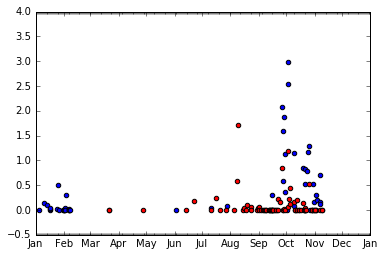

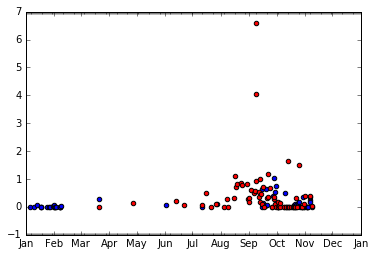

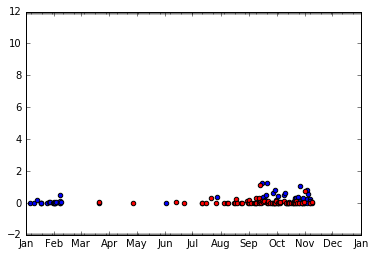

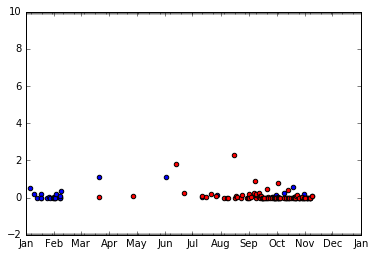

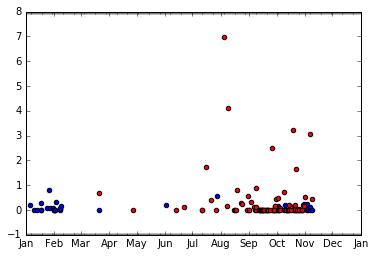

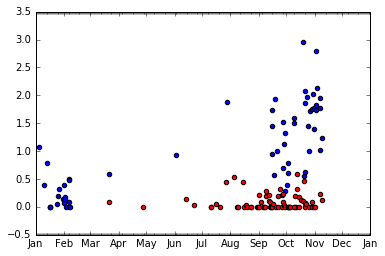

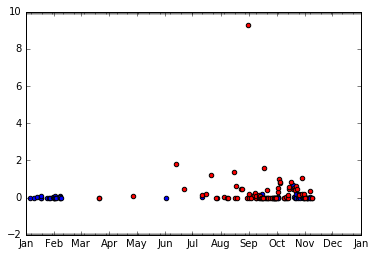

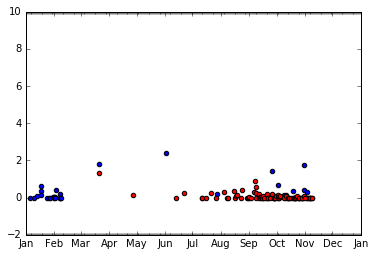

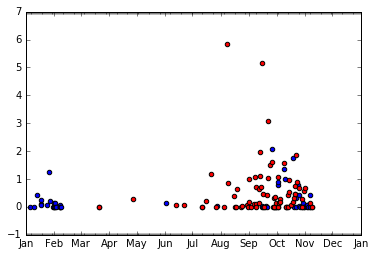

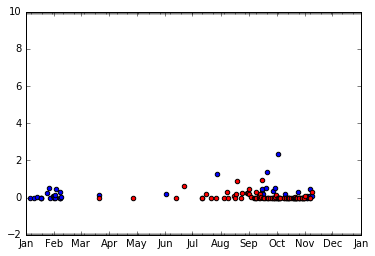

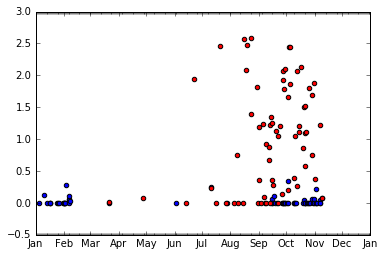

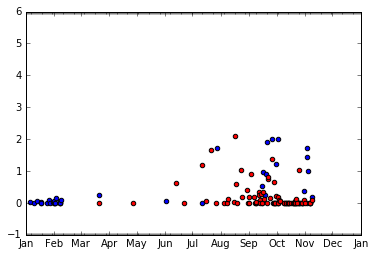

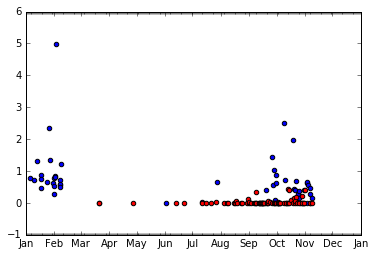

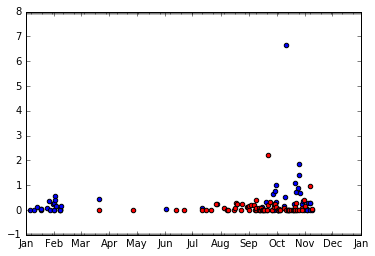

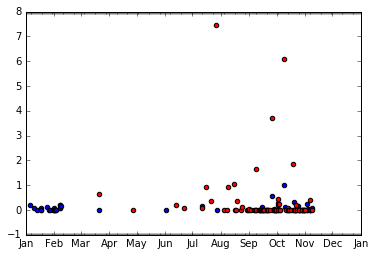

In [153]:
days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

for topic_id in range(n_topics):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(days)
    
    datemin = datetime.date(min(clinton_dates).year+1, 1, 1)
    datemax = datetime.date(max(clinton_dates).year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    
    ax.scatter(clinton_dates,speeches_topics[:len(clinton_speeches), topic_id])
    ax.scatter(trump_dates,speeches_topics[len(clinton_speeches):, topic_id],c='r')
    ax.plot()

In [13]:
# For each speech we keep the top 5 topics
speech_topic_nb = 3
speeches_main_topics = []
for speech_topics in speeches_topics:
    #top_topics = [i for i,val in enumerate(speech_topics) if val>0.01]
    top_topics = sorted(range(len(speech_topics)), key=lambda i: speech_topics[i], reverse=True)[:speech_topic_nb]
    speeches_main_topics.append(top_topics)

In [13]:
# We try a smarter selection process based on clustering to get the main topics of each speech
speeches_main_topics = []
for speech_topics in speeches_topics:
    clust = cluster.SpectralClustering(n_clusters=2)
    clust.fit_predict(speech_topics.reshape(-1,1))
    clust_1 = [i for i in range(len(speech_topics)) if clust.labels_[i] == 1]
    clust_0 = [i for i in range(len(speech_topics)) if clust.labels_[i] == 0]
    # We add the cluster with the highest values
    if np.mean([speech_topics[i] for i in clust_0]) > np.mean([speech_topics[i] for i in clust_1]):
        speeches_main_topics.append(clust_0)
    else:
        speeches_main_topics.append(clust_1)

(array([ 21.,  35.,  51.,  31.,  15.,   8.,   1.,   0.,   1.,   1.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <a list of 10 Patch objects>)

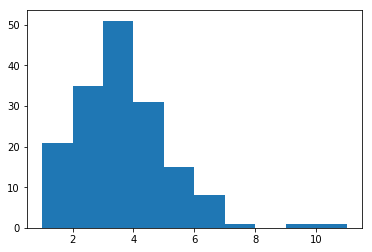

In [14]:
plt.hist([len(l) for l in speeches_main_topics])

In [16]:
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.yaxis.set_major_locator(months)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.yaxis.set_minor_locator(days)

datemin = datetime.date(min(clinton_dates).year, 8, 1)
datemax = datetime.date(max(clinton_dates).year, 12, 1)
ax.set_ylim(datemin, datemax)
ax.set_xlim(-0.2, len(topics_labels)*0.4)
ax.set_xticklabels(topics_labels, rotation=90)
ax.set_xticks([0+i*0.4 for i in list(range(len(topics_labels)))])
    
# We do the plot for Clinton first
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):    
    c=ax.scatter([t*0.4-0.1 for t in topic],[clinton_dates[i]]*len(topic), c='b', s=speeches_topics[i, topic]*20)
    
# We do it for trump next
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):    
    t=ax.scatter([t*0.4+0.1 for t in topic], [trump_dates[i]]*len(topic), c='r', s=speeches_topics[len(clinton_dates)+i, topic]*20)
    
# We also add dashed vertical lines to separate topics
for i in [0+i*0.4 for i in list(range(len(topics_labels)))]:
    plt.axvline(x=i, ls="dashed", color="k")
    plt.axvline(x=i+0.2, color="k", linewidth=3)

fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()
lgnd = ax.legend([c,t],["Clinton speech", "Trump speech"], loc=3, scatterpoints=1)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
ax.plot()
fig.savefig("Campaign_topics.pdf")

In [17]:
# We now apply the signature on it, so we modify our data to fit in there
# We begin with Clinton signature
jar_path = "./code_these_clement/resources/signatures.jar"
clinton_dataset = []
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):
    if topic:
        clinton_dataset.append({'timestamp':int(clinton_dates[i].timestamp()), 'products':["%05d" % t for t in topic]})
sign_clinton = compute_sky_signature(clinton_dataset, jar_path, 0.1, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

trump_dataset = []
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):
    if topic:
        trump_dataset.append({'timestamp':int(trump_dates[i].timestamp()), 'products':["%05d" % t for t in topic]})
sign_trump = compute_sky_signature(trump_dataset, jar_path, 0.1, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

In [19]:
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.yaxis.set_major_locator(months)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.yaxis.set_minor_locator(days)
ax.spines['right'].set_visible(False)

datemin = datetime.date(min(clinton_dates).year+1, 7, 1)
datemax = datetime.date(max(clinton_dates).year, 11, 15)
ax.set_ylim(datemin, datemax)
ax.set_xlim(-0.2, len(topics_labels)*0.4-0.2)#+0.1)
ax.set_xticklabels(topics_labels, rotation=90)# + ["Education policy + main topics", "Illegal immigration + main topics"], rotation=90)
ax.set_xticks([0+i*0.4 for i in list(range(len(topics_labels)))])# + [0.4*n_topics-0.1, 0.4*n_topics])
    
# We do the plot for Clinton first
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):    
    c=ax.scatter([t*0.4-0.1 for t in topic],[clinton_dates[i]]*len(topic), c='b', s=speeches_topics[i, topic]*50)
    
# We do it for trump next
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):    
    t=ax.scatter([t*0.4+0.1 for t in topic], [trump_dates[i]]*len(topic), c='r', s=speeches_topics[len(clinton_dates)+i, topic]*50)
    
# We also add dashed vertical lines to separate topics
for i in [0+i*0.4 for i in list(range(len(topics_labels)))]:
    plt.axvline(x=i, ls="dashed", color="k")
    plt.axvline(x=i+0.2, color="k", linewidth=3)
    
# # We now add the bloc plots
# chosen_sign = sign_trump[2]
# # print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
# for b in chosen_sign["blocs"]:
#     ax.vlines(0.4*n_topics-0.1, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='g', lw=6)
# chosen_sign = sign_trump[3]
# # print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
# for b in chosen_sign["blocs"]:
#     ax.vlines(0.4*n_topics, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='c', lw=6)
#     
# # We also add patches over the segments
# start = mdates.date2num(datetime.datetime(2016, 8, 27))
# end = mdates.date2num(datetime.datetime(2016, 9, 30))
# ax.add_patch(patches.Rectangle((0.4*n_topics-0.13, start),0.06, end-start,fill=False, edgecolor="black", linewidth=1.5))
# end = mdates.date2num(datetime.datetime(2016, 9, 25))
# ax.add_patch(patches.Rectangle((0.4*n_topics-0.03, start),0.06, end-start,fill=False, edgecolor="black", linewidth=1.5))
# 
# start = mdates.date2num(datetime.datetime(2016, 9, 28))
# end = mdates.date2num(datetime.datetime(2016, 11, 3))
# ax.add_patch(patches.Rectangle((0.4*n_topics-0.03, start),0.06, end-start,fill=False, edgecolor="black", linewidth=1.5))
# start = mdates.date2num(datetime.datetime(2016, 10, 2))
# ax.add_patch(patches.Rectangle((0.4*n_topics-0.13, start),0.06, end-start,fill=False, edgecolor="black", linewidth=1.5))
# 
# # We also add the texts
# bbox_props = dict(boxstyle="circle,pad=0.1", fc="None")
# start = mdates.date2num(datetime.datetime(2016, 8, 23))
# ax.text(0.4*n_topics-0.1, start, "1", ha="center", va="center", size=15, bbox=bbox_props)
# ax.text(0.4*n_topics, start, "2", ha="center", va="center", size=15, bbox=bbox_props)
# 
# start = mdates.date2num(datetime.datetime(2016, 11, 7))
# ax.text(0.4*n_topics-0.1, start, "3", ha="center", va="center", size=15, bbox=bbox_props)
# ax.text(0.4*n_topics, start, "4", ha="center", va="center", size=15, bbox=bbox_props)

fig.set_figheight(10)
fig.set_figwidth(18)
plt.tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()
lgnd = ax.legend([c,t],["Clinton speech", "Trump speech"], loc=3, scatterpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
ax.plot()
fig.savefig("campaign_topics_blocs_rects_no_episodes.pdf")

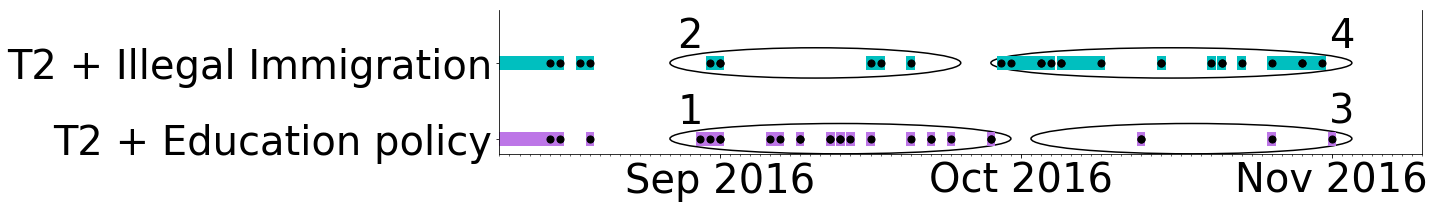

In [18]:
# We make a plot with the episodes alone
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(days)
ax.set_yticks([0,1])
ax.set_yticklabels(["T2 + Education policy", "T2 + Illegal Immigration"])

datemin = datetime.date(min(clinton_dates).year+1, 8, 10)
datemax = datetime.date(max(clinton_dates).year, 11, 10)
ax.set_xlim(datemin, datemax)
ax.set_ylim(-0.2, 1.7)
# ax.set_yticklabels(["Education policy + main topics", "Illegal immigration + main topics"])
# ax.set_yticks([0,1])

def in_sign_blocs(blocs, dates, date):
    for b in blocs:
        if dates[b[0]]<= date <= dates[b[1]]:
            return True
    return False

# We now add the bloc plots
chosen_sign = sign_trump[2]
for b in chosen_sign["blocs"]:
    ax.hlines(0, trump_dates[b[0]]-datetime.timedelta(hours=10),  trump_dates[b[1]]+datetime.timedelta(hours=10), color='#BD76E7', lw=14)
chosen_sign = sign_trump[3]
for b in chosen_sign["blocs"]:
    ax.hlines(1, trump_dates[b[0]]-datetime.timedelta(hours=10), trump_dates[b[1]]+datetime.timedelta(hours=10), color='c', lw=14)
    
# We also add patches over the segments
start = mdates.date2num(datetime.datetime(2016, 8, 27))
end = mdates.date2num(datetime.datetime(2016, 9, 30))
ax.add_patch(patches.Ellipse(((end+start)/2, 0), end-start, 0.4, fill=False, edgecolor="black", linewidth=1.5))
end = mdates.date2num(datetime.datetime(2016, 9, 25))
ax.add_patch(patches.Ellipse(((end+start)/2, 1), end-start, 0.4, fill=False, edgecolor="black", linewidth=1.5))

start = mdates.date2num(datetime.datetime(2016, 9, 28))
end = mdates.date2num(datetime.datetime(2016, 11, 3))
ax.add_patch(patches.Ellipse(((end+start)/2,1), end-start, 0.4, fill=False, edgecolor="black", linewidth=1.5))
start = mdates.date2num(datetime.datetime(2016, 10, 2))
ax.add_patch(patches.Ellipse(((end+start)/2, 0),end-start, 0.4, fill=False, edgecolor="black", linewidth=1.5))

# We also add the texts
bbox_props = dict(boxstyle="circle,pad=0.1", fc="None")
start = mdates.date2num(datetime.datetime(2016, 8, 23))
ax.text(start+(end-start)/12, 0.35, "1", ha="center", va="center", size=40)
ax.text(start+(end-start)/12, 1.35, "2", ha="center", va="center", size=40)

start = mdates.date2num(datetime.datetime(2016, 11, 7))
ax.text(start-5, 0.35, "3", ha="center", va="center", size=40)
ax.text(start-5, 1.35, "4", ha="center", va="center", size=40)

in_blocs_1 = [d for d in trump_dates if in_sign_blocs(sign_trump[2]["blocs"], trump_dates, d)]
ax.scatter(in_blocs_1, [0]*len(in_blocs_1), s=50, zorder=2, c="k")
in_blocs_2 = [d for d in trump_dates if in_sign_blocs(sign_trump[3]["blocs"], trump_dates, d)]
ax.scatter(in_blocs_2, [1]*len(in_blocs_2), s=50, zorder=2, c="k")

fig.set_figheight(3)
fig.set_figwidth(20)
plt.tick_params(axis="both", labelsize=40)
ax.spines['top'].set_visible(False)
fig.tight_layout()
ax.plot()
fig.savefig("episodes_alone_speeches.pdf")

In [41]:
# We now do the most frequent topics to compare it with the signature
clinton_topics_concat = []
for topic in speeches_main_topics[:len(clinton_dates)]:
    clinton_topics_concat.extend(topic)
clinton_topic_counter = Counter(clinton_topics_concat)
clinton_frequent_topics = sorted(clinton_topic_counter.items(), key=lambda a:a[1], reverse=True)
    
trump_topics_concat = []
for topic in speeches_main_topics[len(clinton_dates):]:
    trump_topics_concat.extend(topic)
trump_topic_counter = Counter(trump_topics_concat)
trump_frequent_topics = sorted(trump_topic_counter.items(), key=lambda a:a[1], reverse=True)

In [42]:
print(clinton_frequent_topics)
print(sign_clinton)
print(trump_frequent_topics)
print(sign_trump)

[(5, 53), (12, 51), (13, 25), (2, 23), (11, 22), (0, 21), (9, 18), (1, 14), (3, 14), (7, 14), (8, 13), (14, 9), (4, 4), (10, 4), (6, 3)]
[{'blocs': [[0, 0], [5, 5], [8, 8], [9, 9], [10, 10], [12, 12], [16, 16], [21, 21], [28, 28], [29, 29], [30, 30], [36, 36], [40, 40], [46, 46], [47, 47], [49, 49], [50, 50], [52, 52], [53, 53], [54, 54], [55, 55], [56, 56], [57, 57], [58, 58], [60, 60], [61, 61], [62, 62], [64, 64], [65, 65], [67, 67], [68, 68], [69, 69], [72, 72], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92]], 'signature': [5]}, {'blocs': [[0, 1], [4, 5], [8, 8], [12, 12], [16, 16], [21, 21], [28, 28], [29, 29], [30, 30], [36, 36], [40, 40], [46, 46], [47, 47], [48, 49], [57, 57], [58, 59], [60, 60], [61, 61], [62, 63], [64, 64], [68, 68], [69, 69], [72, 72], [73, 73], [74, 74], [75, 75], [84, 84], [86, 86], [88, 88], [89, 89], [91,

In the next cell, we will look for topics that are frequent but not in the signature.
This means that these topics are usually the result of a trend effect : they got a lot of attention in a rather small time compared to the whole campaign.

In [74]:
# We now do some analysis of the results
# Let's start with the topic analysis: comparing topics in signature with the most frequent ones
print("Clinton anomalies")
for sign in sign_clinton:
    # We take as many frequent items as the one in the signature
    corresponding_top_k = [t[0] for t in clinton_frequent_topics[:len(sign["signature"])]]
    if set(corresponding_top_k) != set(sign["signature"]):
        print("List of different topics: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)-set(sign["signature"])]))
    
print("Trump anomalies")    
print([topics_labels[t[0]] + ":" + str(t[1]) for t in trump_frequent_topics])
for sign in sign_trump:
    # We take as many frequent items as the one in the signature
    corresponding_top_k = [t[0] for t in trump_frequent_topics[:len(sign["signature"])]]
    if set(corresponding_top_k) != set(sign["signature"]):
        print("List of different topics: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)-set(sign["signature"])]))
        #print("top k: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)]))
        #print("Signature: " + ",".join([topics_labels[t] for t in set(sign["signature"])]))

Clinton anomalies
List of different topics: Climate change issues
List of different topics: Climate change issues
List of different topics: Climate change issues
List of different topics: Climate change issues
List of different topics: Communities and police
List of different topics: Communities and police,Climate change issues
List of different topics: Taxes on small businesses,Climate change issues
List of different topics: Communities and police
List of different topics: Climate change issues
List of different topics: Taxes on small businesses
Trump anomalies
['Social policy and critics:50', 'New economic policy:35', 'Illegal immigration:27', 'Education policy:26', 'Communities and police:16', 'Money and wall at border:15', 'Terrorism:10', 'Nuclear issues with Iran:9', 'Criticism of democrats:9', 'Woman as president and voters:8', 'Climate change issues:7', 'Economic policy - wages:6', 'Future challenges for president:5', 'Taxes on small businesses:4', 'Childcare and education:4']
L

Clinton signature topics: Woman as president and voters,Future challenges for president
Trump signature topics: Education policy,Money and wall at border,Illegal immigration,New economic policy,Social policy and critics,Communities and police


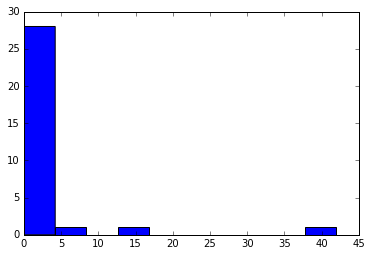

(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   1.        ,   12.09583333,   23.19166667,   34.2875    ,
          45.38333333,   56.47916667,   67.575     ,   78.67083333,
          89.76666667,  100.8625    ,  111.95833333]),
 <a list of 10 Patch objects>)

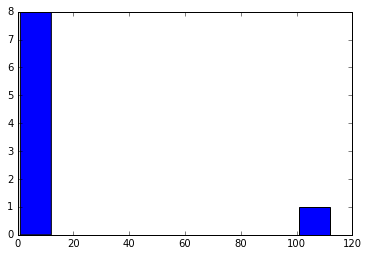

In [73]:
# We now look at the bloc sizes to see if something interesting happens here
# We take the last signature of each candidate, because it is the longest. Other signatures could work too
last_sign_clinton = sign_clinton[1]
last_sign_trump = sign_trump[6]

print("Clinton signature topics: " + ",".join([topics_labels[t] for t in last_sign_clinton["signature"]]))
print("Trump signature topics: " + ",".join([topics_labels[t] for t in last_sign_trump["signature"]]))

clinton_blocks_duration = [(clinton_dates[b[1]].timestamp()-clinton_dates[b[0]].timestamp())/(3600*24) for b in last_sign_clinton["blocs"]]
trump_blocks_duration = [(trump_dates[b[1]].timestamp()-trump_dates[b[0]].timestamp())/(3600*24) for b in last_sign_trump["blocs"]]

plt.hist(clinton_blocks_duration)
plt.show()
plt.hist(trump_blocks_duration)

Clinton signature topics (19 times): Education policy,New economic policy,Social policy and critics
Trump signature topics (19 times): Illegal immigration,New economic policy,Social policy and critics


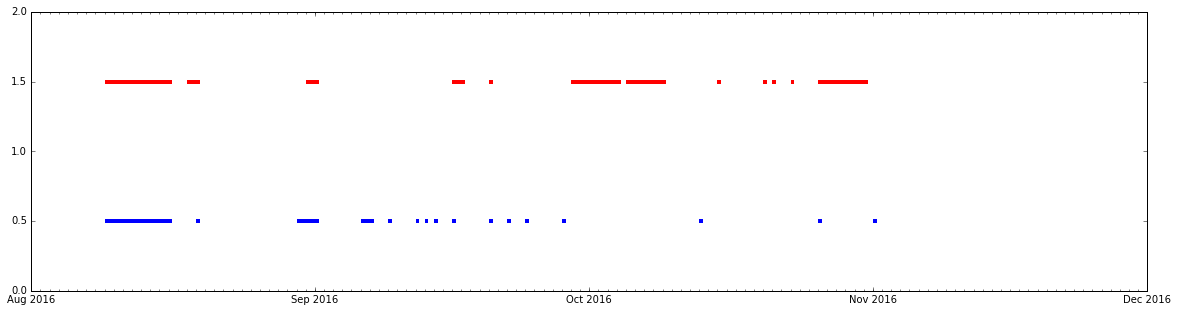

In [46]:
# We are gonna work on these blocs cause they are our main contributions
# First let's look at clinton's blocs
[(clinton_dates[b[1]].timestamp()-clinton_dates[b[0]].timestamp())/(3600*24) for b in last_sign_clinton["blocs"]]
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(days)

datemin = datetime.date(min(clinton_dates).year+1, 8, 1)
datemax = datetime.date(max(clinton_dates).year, 12, 1)
ax.set_xlim(datemin, datemax)
ax.set_ylim(0,2)

chosen_sign = sign_trump[2]
print("Clinton signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.hlines(0.5, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='b', lw=4)
    
chosen_sign = sign_trump[3]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.hlines(1.5, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='r', lw=4)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.show()

Trump signature topics (19 times): Illegal immigration,New economic policy,Social policy and critics
[[3, 3], [8, 8], [12, 14], [15, 16], [20, 21], [22, 22], [35, 36], [37, 37], [44, 46], [47, 48], [50, 51], [55, 55], [56, 56], [59, 59], [60, 60], [61, 61], [63, 63], [64, 65], [66, 67]]
Trump signature topics (19 times): Education policy,New economic policy,Social policy and critics
[[3, 3], [5, 8], [12, 14], [16, 16], [19, 21], [22, 22], [24, 25], [27, 27], [30, 30], [31, 31], [33, 33], [35, 35], [37, 37], [39, 39], [40, 40], [43, 43], [54, 54], [64, 64], [68, 68]]


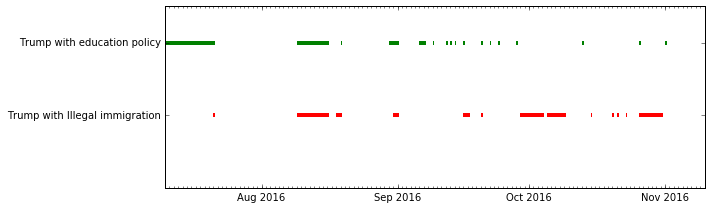

In [49]:
# We study why trump has different signatures at 15 blocs
days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(days)

datemin = datetime.date(min(trump_dates).year+1, 7, 10)
datemax = datetime.date(max(trump_dates).year, 11, 10)
ax.set_xlim(datemin, datemax)
ax.set_ylim(0,0.5)

chosen_sign = sign_trump[3]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
print(chosen_sign["blocs"])
for b in chosen_sign["blocs"]:
    ax.hlines(0.2, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='r', lw=4)
    
chosen_sign = sign_trump[2]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
print(chosen_sign["blocs"])
for b in chosen_sign["blocs"]:
    ax.hlines(0.4, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='g', lw=4)

ax.set_yticks([0.2,0.4])
ax.set_yticklabels(["Trump with Illegal immigration", "Trump with education policy"])
fig.set_figheight(3)
fig.set_figwidth(10)
fig.tight_layout()
#plt.savefig("trump_blocs.pdf")
plt.show()

In [15]:
# To compare ourselves with the method that uses words, let's compute signatures on counts
# We now transform tweets using vectorizers
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(clinton_speeches)
inverse_dict_clinton = {v:k for k,v in count_vectorizer.vocabulary_.items()}

In [33]:
clinton_word_dataset = []
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")
jar_path = "./code_these_clement/resources/signatures.jar"

for i, topic in enumerate(count_vectors):
    speech_words = ["%05d" % t for t in find(topic)[1]]
    if speech_words:
        clinton_word_dataset.append({'timestamp':int(clinton_dates[i].timestamp()), 'products':speech_words})
sign_clinton = compute_sky_signature(clinton_word_dataset, jar_path, 60, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

In [34]:
last_sign_clinton = sign_clinton[-1]
print("Clinton signature topics: " + ",".join([inverse_dict_clinton[t] for t in last_sign_clinton["signature"]]))

Clinton signature topics: year,many,president,thing,life,way,time,day,great,good,much,right


In [36]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [95]:
# We now try to compute the topics of each candidate based on a fixed window size
clinton_dataset_fixed_window = []

nb_windows = 10

#min_clinton_date = min(clinton_dates)
min_clinton_date = datetime.datetime(2016, 9, 15)
max_clinton_date = max(clinton_dates)

# Next, we compute the topics in all windows for Clinton
clinton_delta = (max_clinton_date+datetime.timedelta(days=15)-min_clinton_date)/nb_windows
clinton_window_topics = []
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):
    if topic:
        current_window = max(-1, int((clinton_dates[i]-min_clinton_date)/clinton_delta))
        if current_window >= 0:
            if len(clinton_dataset_fixed_window)<=current_window:
                clinton_dataset_fixed_window.append(set(topic))
            else:
                clinton_dataset_fixed_window[current_window] |= set(topic)

In [96]:
recurrent_topics_clinton = set(range(0, len(topics_labels)))
for t in clinton_dataset_fixed_window:
    recurrent_topics_clinton &= t
print([topics_labels[i] for i in recurrent_topics_clinton])
print(clinton_dataset_fixed_window)

['Future challenges for president', 'Woman as president and voters']
[{1, 2, 5, 9, 11, 12}, {0, 1, 2, 5, 7, 8, 11, 12, 13}, {0, 1, 2, 5, 7, 8, 9, 11, 12, 13}, {0, 1, 2, 5, 8, 9, 12, 13, 14}, {8, 12, 5}, {0, 5, 8, 12, 13, 14}, {0, 1, 2, 4, 5, 7, 11, 12, 13}, {0, 1, 2, 5, 8, 9, 11, 12, 13}]


In [109]:
# We now try to compute the topics of each candidate based on a fixed window size
trump_dataset_fixed_window = []

nb_windows = 6

min_trump_date = datetime.datetime(2016, 8, 10)
#min_trump_date = min(trump_dates[2:]) # We ignore the first 2 speeches as they are way before the next ones
max_trump_date = max(trump_dates)

# Next, we compute the topics in all windows for Trump
trump_delta = (max_trump_date+datetime.timedelta(days=15)-min_trump_date)/nb_windows
trump_window_topics = []
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):
    if topic:
        current_window = max(-1, int((trump_dates[i]-min_trump_date)/trump_delta))
        if current_window >= 0:
            if len(trump_dataset_fixed_window)<=current_window:
                trump_dataset_fixed_window.append(set(topic))
            else:
                trump_dataset_fixed_window[current_window] |= set(topic)
print(min_trump_date)
print(max_trump_date)

2016-08-10 00:00:00
2016-11-09 00:00:00


In [111]:
recurrent_topics_trump = set(range(0, len(topics_labels)))
for t in trump_dataset_fixed_window:
    recurrent_topics_trump &= t
print([topics_labels[i] for i in recurrent_topics_trump])
print(trump_dataset_fixed_window)

['Social policy and critics', 'Money and wall at border']
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14}, {0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14}, {0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14}, {1, 2, 4, 5, 6, 8, 10, 11, 12, 13}, {9, 10, 4, 13}]


In [38]:
# We also try a less dumb partitioning that contains an equal number of speech in each window
trump_dataset_fixed_window = []
min_trump_date = datetime.datetime(2016, 8, 10)
#min_trump_date = min(trump_dates[2:]) # We ignore the first 2 speeches as they are way before the next ones
max_trump_date = max(trump_dates)

nb_windows = 6
nb_speech_per_window = int(len([trump_dates[i] for i,s in enumerate(speeches_main_topics[len(clinton_dates):]) 
                                if min_trump_date <= trump_dates[i] <= max_trump_date])/nb_windows)

# Next, we compute the topics in all windows for Trump
trump_window_topics = []
current_window = 0
nb_speech = 0
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):
    if topic:
        if min_trump_date <= trump_dates[i] <= max_trump_date:
            if current_window == 0 and nb_speech == 0:
                trump_dataset_fixed_window.append(set(topic))
                nb_speech += 1
                current_window += 1
            elif nb_speech == nb_speech_per_window and current_window < nb_windows:
                trump_dataset_fixed_window.append(set(topic))
                nb_speech = 1
                current_window += 1
            else:
                trump_dataset_fixed_window[current_window-1] |= set(topic)
                nb_speech += 1
print(nb_speech_per_window)

9


In [39]:
recurrent_topics_trump = set(range(0, len(topics_labels)))
for t in trump_dataset_fixed_window:
    recurrent_topics_trump &= t
print([topics_labels[i] for i in recurrent_topics_trump])
print(trump_dataset_fixed_window)

['New economic policy', 'Education policy', 'Social policy and critics', 'Illegal immigration']
[{1, 3, 4, 6, 7, 8, 9, 10, 11, 14}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14}, {1, 2, 3, 6, 8, 9, 10, 11, 13}, {0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14}, {0, 1, 3, 4, 5, 6, 8, 10, 12}, {1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14}]


In [40]:
print(clinton_dates[0])

2015-04-12 00:00:00
